<a href="https://colab.research.google.com/github/THANNAGA/Lagrangian/blob/main/GLV_bounded_lagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

!pip install git+https://github.com/cooper-org/cooper.git
import cooper
from copy import deepcopy as copy

  Cloning https://github.com/cooper-org/cooper.git to /tmp/pip-req-build-n4twabju
  Running command git clone --filter=blob:none --quiet https://github.com/cooper-org/cooper.git /tmp/pip-req-build-n4twabju
  Resolved https://github.com/cooper-org/cooper.git to commit eae7c5a68563b83410913c8b24e99b70e32694f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Lagrangian classes

In [124]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.input_dim = input_dim
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        # Freeze the diagonal: add a hook to zero out the diagonal elements of the gradient
        self.linear.weight.register_hook(lambda grad: grad - torch.diag_embed(torch.diag(grad)))

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        outputs = self.linear(x)
        return outputs

class LogisticRegressionFixed(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionFixed, self).__init__()
        self.input_dim = input_dim

        # Initialize the trainable and non-trainable components of the weight matrix
        self.trainable_weights = torch.nn.Parameter(torch.randn(input_dim, output_dim))
        self.untrainable_weights = torch.diag(torch.full((min(input_dim, output_dim),), -1.))

        # Set the diagonal elements of trainable_weights to zero
        #with torch.no_grad():
        #    self.trainable_weights -= torch.diag_embed(torch.diag(self.trainable_weights))

        # Add a hook to zero out the diagonal elements of the gradient
        self.trainable_weights.register_hook(lambda grad: grad - torch.diag_embed(torch.diag(grad)))

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        # Form the full weight matrix from its components
        full_weights = self.trainable_weights + self.untrainable_weights

        outputs = x @ full_weights
        return outputs


class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        ineq_defect = model.linear.weight.norm(dim=1) - 1

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class SumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class TemplateConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=None, eq_defect=eq_defect)

class TemplateSumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=eq_defect)


class TemplateSumConstrainedLogRegMod(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)
        #weights = model.trainable_weights + model.untrainable_weights
        weights = model.linear.weight

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = weights.sum(dim=1)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (weights.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=eq_defect)

### Defining a toy weight matrix sign template in the context of Interactive Activation

In [125]:
# Define a function to check if a token is a word
def is_word(token):
    return token.isalpha()

# Define a function to get the position of a letter/position token
def get_position(token):
    return int(token[1:]) if not is_word(token) else None

def contains_letter(token, letter):
    return letter in token


def create_matrix(tokens=[], WtoL=0.01, LtoW=0.05, LtoL=-1.0, WtoW=-0.5, show=True):
  # Initialize the adjacency matrix with all zeroes
  adjacency_matrix = np.zeros((len(tokens), len(tokens)))

  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if i == j:
              continue  # a token is not connected to itself
          if is_word(tokens[i]) and is_word(tokens[j]):
              # Two word tokens are always connected with a -1
              adjacency_matrix[i, j] = WtoW
          elif not is_word(tokens[i]) and not is_word(tokens[j]) and get_position(tokens[i]) == get_position(tokens[j]):
              # Two letter/position tokens are connected with a -1 if they have the same position
              adjacency_matrix[i, j] = LtoL

  # Iterate over the tokens again to add +1 connections
  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if is_word(tokens[i]) and not is_word(tokens[j]) and contains_letter(tokens[i], tokens[j][0]):
              # If a word token contains a letter/position token, there is a positive LtoWExc connection between them
              adjacency_matrix[i, j] = WtoL
              adjacency_matrix[j, i] = LtoW
  np.fill_diagonal(adjacency_matrix, -1)

  if show:
    n = len(tokens); print (n)
    plt.imshow(adjacency_matrix);plt.colorbar()
    plt.xticks(np.arange(n),tokens, rotation = 45)
    # Move xticks to the top using plt interface
    plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
    plt.yticks(np.arange(n),tokens)
    plt.show()

  return adjacency_matrix

def adjust_eigen(A):
  # adjust diagonal for negative real parts of all eigenvalues
  eigenvalues = np.linalg.eigvals(A)
  max_real_part = np.max(eigenvalues.real)
  print('max_real_part', max_real_part)
  if max_real_part > 0:
    A = A - 1.001*max_real_part * np.eye(A.shape[0])
  return A

8
8


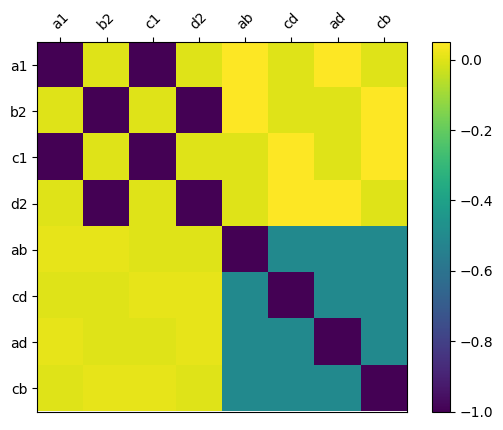

In [126]:
tokens = ['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad', 'cb']
#tokens = ['a1', 'b2', 'ab']
n = len(tokens); print (n)
A = create_matrix(tokens = tokens)

### Defnining a toy dataset in the context of interactive activation

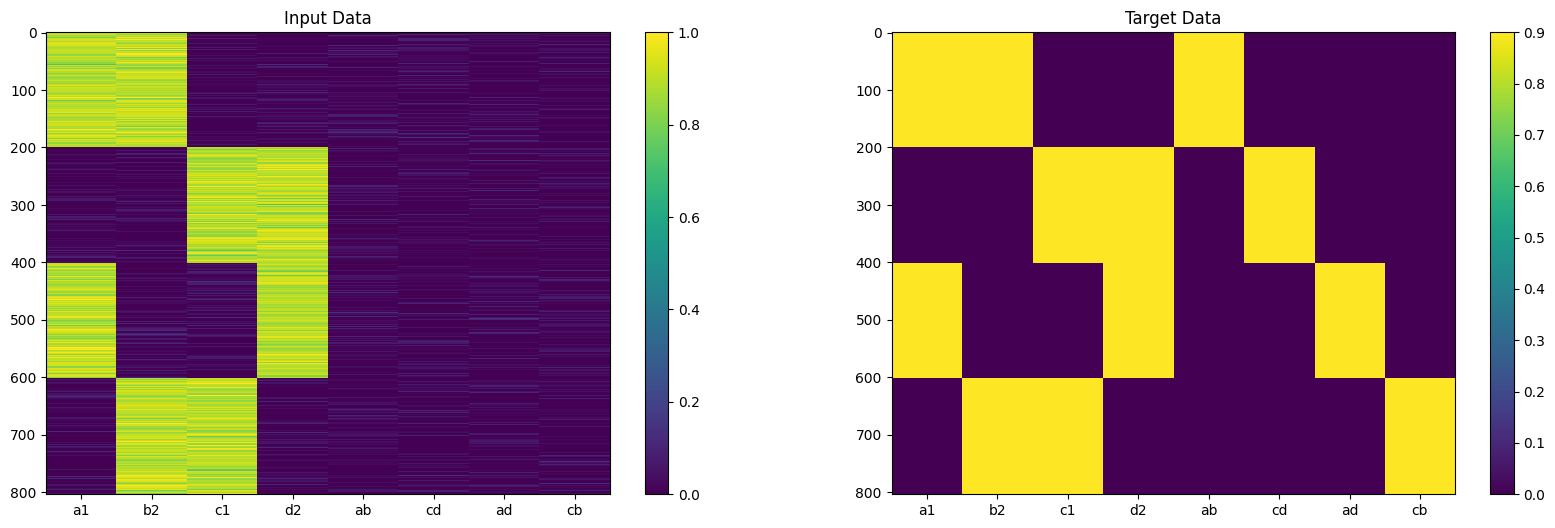

In [127]:
def create_dataset(tokens, show = True):

  # Adjust the word to letter mapping to account for the position of the letters
  word_to_letters = {word: [f'{letter}{i+1}' for i, letter in enumerate(word)] for word in tokens if is_word(word)}

  # Initialize empty lists for input and target data
  input_data = []
  target_data = []

  # Iterate over all word tokens
  value = 0.9
  for word, letters in word_to_letters.items():
      # Create input and target vectors for each word
      input_vector = [value if token in letters else 0 for token in tokens]
      target_vector = input_vector.copy()
      target_vector[tokens.index(word)] = value  # Set the corresponding word token to 1 in the target vector

      # Add the input and target vectors to the data
      input_data.append(input_vector)
      target_data.append(target_vector)

      # Create k variants with small perturbations
      for _ in range(200):
          perturbed_input_vector = [value + 0.05 * np.random.randn() for value in input_vector]
          # Make sure values are within [0, 1]
          perturbed_input_vector = np.clip(perturbed_input_vector, 0, 1)
          input_data.append(perturbed_input_vector)
          target_data.append(target_vector)

  # Convert the lists to numpy arrays
  input_data = np.array(input_data)
  target_data = np.array(target_data)

  if show:

    # Plot the input and target data
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

    # Input data
    cax = ax[0].imshow(input_data, cmap='viridis', aspect='auto', interpolation='none')
    fig.colorbar(cax, ax=ax[0])
    ax[0].set_title('Input Data')
    ax[0].set_xticks(np.arange(n))
    ax[0].set_xticklabels(tokens)

    # Target data
    cax = ax[1].imshow(target_data, cmap='viridis', aspect='auto', interpolation='none')
    fig.colorbar(cax, ax=ax[1])
    ax[1].set_title('Target Data')
    ax[1].set_xticks(np.arange(n))
    ax[1].set_xticklabels(tokens)

    plt.show()

  return input_data, target_data

input_data, target_data = create_dataset(tokens)

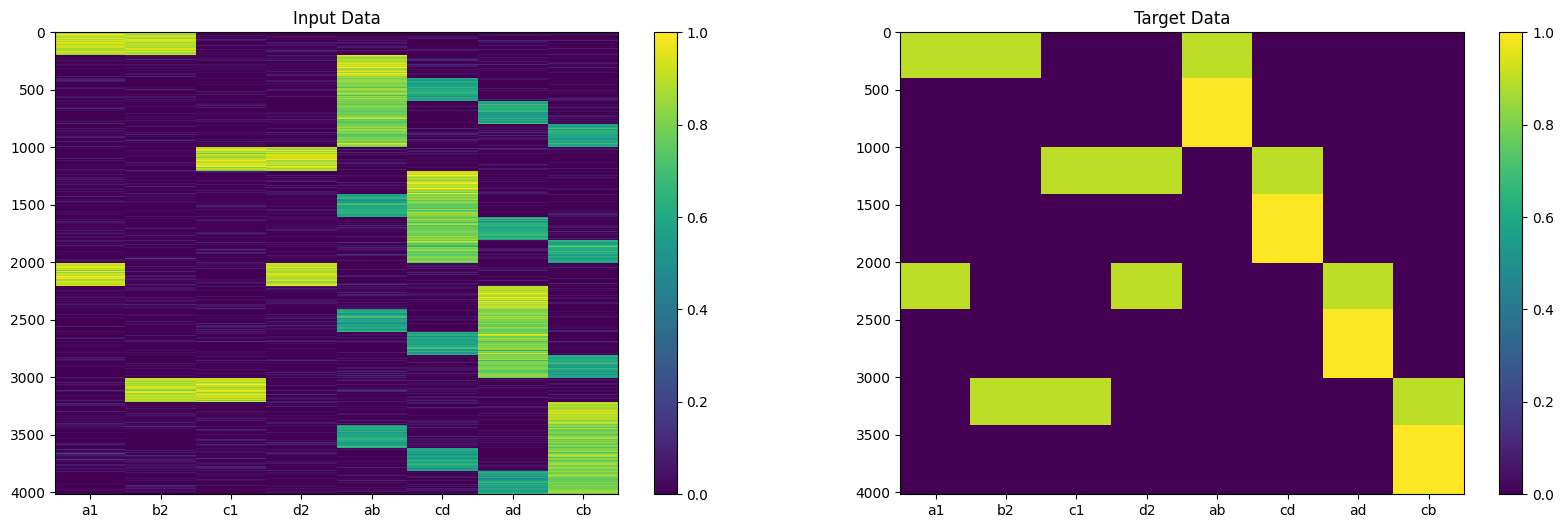

In [128]:
def create_dataset_expanded(tokens, show=True):

    # Adjust the word to letter mapping to account for the position of the letters
    word_to_letters = {word: [f'{letter}{i+1}' for i, letter in enumerate(word)] for word in tokens if is_word(word)}

    # Initialize empty lists for input and target data
    input_data = []
    target_data = []

    value = 0.9

    for word, letters in word_to_letters.items():
        # Create input and target vectors for each word
        input_vector = [value if token in letters else 0 for token in tokens]
        target_vector = input_vector.copy()
        target_vector[tokens.index(word)] = value

        # Add the input and target vectors to the data
        input_data.append(input_vector)
        target_data.append(target_vector)

        # Create k variants with small perturbations for constituent letters
        for _ in range(200):
            perturbed_input_vector = [value + 0.05 * np.random.randn() for value in input_vector]
            perturbed_input_vector = np.clip(perturbed_input_vector, 0, 1)
            input_data.append(perturbed_input_vector)
            target_data.append(target_vector)

        # New data generation for noisy one-hot word encoding
        one_hot_vector = [0] * len(tokens)
        one_hot_vector[tokens.index(word)] = value
        for _ in range(201):  # 201 times to match the original's 1 clean + 200 noisy
            perturbed_one_hot_vector = [value + 0.05 * np.random.randn() for value in one_hot_vector]
            perturbed_one_hot_vector = np.clip(perturbed_one_hot_vector, 0, 1)
            input_data.append(perturbed_one_hot_vector)
            target_data.append(target_vector)

        # New data generation for dual-word activation
        for second_word in word_to_letters.keys():
            if word != second_word:
                dual_word_input = [0] * len(tokens)
                dual_word_input[tokens.index(word)] = 0.8
                dual_word_input[tokens.index(second_word)] = 0.6

                dual_word_target = dual_word_input.copy()
                dual_word_target[tokens.index(word)] = 1
                dual_word_target[tokens.index(second_word)] = 0

                input_data.append(dual_word_input)
                target_data.append(dual_word_target)

                # Adding noisy variants of dual-word activation
                for _ in range(200):  # 200 noisy perturbations
                    perturbed_dual_word_input = [value + 0.05 * np.random.randn() for value in dual_word_input]
                    perturbed_dual_word_input = np.clip(perturbed_dual_word_input, 0, 1)
                    input_data.append(perturbed_dual_word_input)
                    target_data.append(dual_word_target)

    # Convert the lists to numpy arrays
    input_data = np.array(input_data)
    target_data = np.array(target_data)

    if show:
        n = len(tokens)  # Define 'n' which was missing in the original code

        # Plot the input and target data
        fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

        # Input data
        cax = ax[0].imshow(input_data, cmap='viridis', aspect='auto', interpolation='none')
        fig.colorbar(cax, ax=ax[0])
        ax[0].set_title('Input Data')
        ax[0].set_xticks(np.arange(n))
        ax[0].set_xticklabels(tokens)

        # Target data
        cax = ax[1].imshow(target_data, cmap='viridis', aspect='auto', interpolation='none')
        fig.colorbar(cax, ax=ax[1])
        ax[1].set_title('Target Data')
        ax[1].set_xticks(np.arange(n))
        ax[1].set_xticklabels(tokens)

        plt.show()

    return input_data, target_data

input_data, target_data = create_dataset_expanded(tokens)

### Training with lagrangian

In [129]:
#cmp = NormConstrainedLogReg(); equality = False
#cmp = SumConstrainedLogReg(); equality = False
#cmp = TemplateConstrainedLogReg()
#cmp = TemplateSumConstrainedLogReg()
cmp = TemplateSumConstrainedLogRegMod()
formulation = cooper.LagrangianFormulation(cmp)

#model = LogisticRegressionFixed(A.shape[0], A.shape[1])
model = LogisticRegression(A.shape[0], A.shape[1])
# Initialize the model's weights with A
A_tensor = torch.tensor(A, dtype=torch.float32)
model.linear.weight.data = nn.Parameter(A_tensor)

# primal_optimizer = cooper.optim.ExtraSGD(model.parameters(), lr=1e-3, momentum=0.9)
# dual_optimizer = cooper.optim.partial_optimizer(cooper.optim.ExtraSGD, lr=5e-3)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=5e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [130]:
epochs = 10000
iter_num = 0
state_history = OrderedDict()

# shuffle
shuffled_indices = np.arange(len(input_data))
np.random.shuffle(shuffled_indices)
input_data_shuffled = input_data[shuffled_indices]
target_data_shuffled = target_data[shuffled_indices]

# Set the diagonal elements to -1
#np.fill_diagonal(A, -1)
template = torch.from_numpy(np.sign(A)).float()
inputs = torch.from_numpy(input_data_shuffled).float()
targets = torch.from_numpy(target_data_shuffled).float()

for epoch in range(epochs):
      coop.zero_grad()
      lagrangian = formulation.composite_objective(
          cmp.closure, model, inputs, targets, template
        )
      formulation.custom_backward(lagrangian)
      coop.step(cmp.closure, model, inputs, targets, template)

      if iter_num % 5 == 0:
          state_history[iter_num] = {
                "cmp": cmp.state,
                "dual": copy(formulation.state()),
            }

      iter_num += 1

In [131]:
iters, loss_history = zip(
    *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
  )

mult_hist = [_["dual"][1].data.numpy() for (foo, _) in state_history.items()]
eq_defect_hist = [_["cmp"].eq_defect.data.numpy() for (foo, _) in state_history.items()]
ineq_defect_hist = [_["cmp"].ineq_defect.data.numpy() for (foo, _) in state_history.items()]

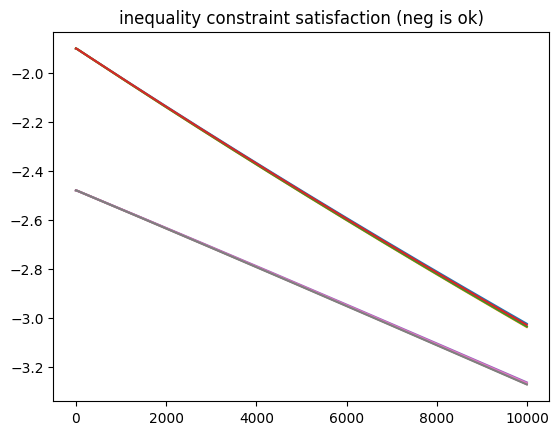

In [132]:
plt.plot(iters, ineq_defect_hist)
plt.title('inequality constraint satisfaction (neg is ok)')
plt.show()

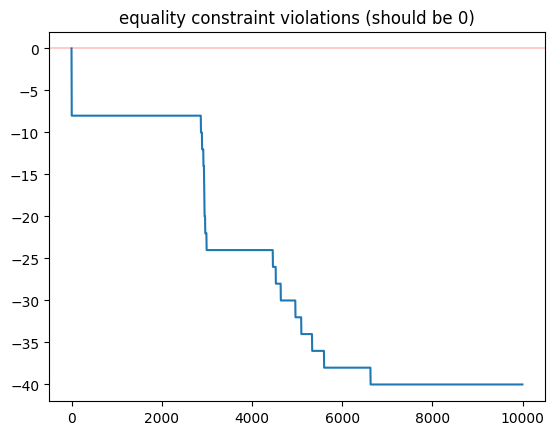

In [133]:
plt.plot(iters, eq_defect_hist)
plt.axhline(0.0, c="r", alpha=0.2)
plt.title('equality constraint violations (should be 0)')
plt.show()

Text(0.5, 1.0, 'Loss history')

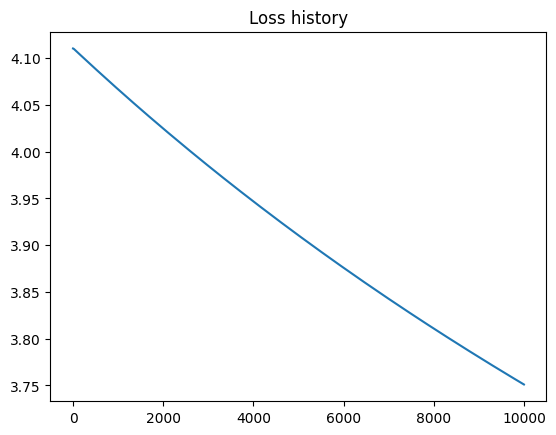

In [134]:
plt.plot(iters, loss_history)
plt.title('Loss history')

In [135]:
def check_matrix_conditions(matrix, verbose=True):
  # Check if the matrix satisfies the conditions
  eigenvalues = np.linalg.eigvals(matrix)
  eigenvalues_real_parts = np.real(eigenvalues)
  row_sums = matrix.sum(axis=1)

  # All eigenvalues have negative real parts
  eigenvalues_condition = np.all(eigenvalues_real_parts < 0)

  # The sum of each row is negative
  row_sums_condition = np.all(row_sums < 0)

  # The matrix contains positive elements
  positive_elements_condition = np.any(matrix > 0)

  if verbose:
    print ('All eigenvalues have negative real parts:', eigenvalues_condition)
    print ('The sum of each row is negative:', row_sums_condition)
    print ('The matrix contains positive elements:', positive_elements_condition)

  return eigenvalues_condition, row_sums_condition, positive_elements_condition

max_real_part 0.47052032


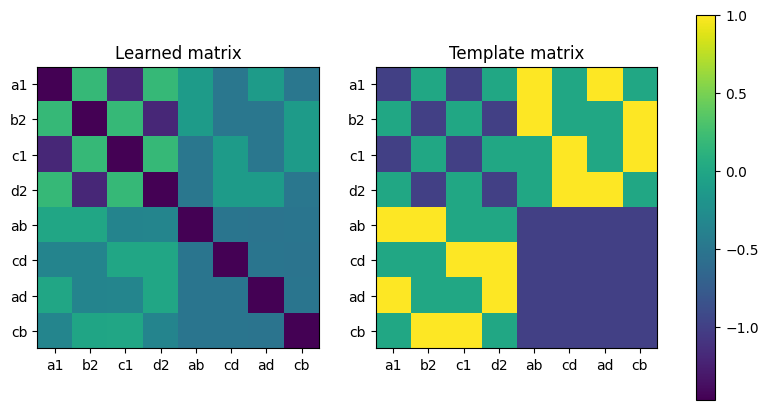

All eigenvalues have negative real parts: True
The sum of each row is negative: True
The matrix contains positive elements: True
[[-1.47099084  0.18683484 -1.19747317  0.1871158  -0.11348678 -0.48894635
  -0.11159426 -0.48827761]
 [ 0.18580832 -1.47099084  0.18368359 -1.19708097 -0.11269667 -0.48926097
  -0.49336758 -0.11632831]
 [-1.19871676  0.18372731 -1.47099084  0.1858872  -0.49099126 -0.11211678
  -0.49025691 -0.11483216]
 [ 0.18558678 -1.19757795  0.18553427 -1.47099084 -0.49193397 -0.1126014
  -0.11025141 -0.48952344]
 [-0.0103224  -0.00601321 -0.35560012 -0.35018009 -1.47099084 -0.51422387
  -0.51664114 -0.51234883]
 [-0.35483411 -0.35365328 -0.00922569 -0.01081569 -0.51263118 -1.47099084
  -0.5150587  -0.51617545]
 [-0.0132805  -0.35201141 -0.35057029 -0.01264525 -0.5120092  -0.51408893
  -1.47099084 -0.51403838]
 [-0.34985894 -0.0135392  -0.01119505 -0.35487869 -0.5133127  -0.51467019
  -0.51641065 -1.47099084]]


In [136]:
A = model.linear.weight.detach().numpy()
A = adjust_eigen(A)

# Determine the common color limits
vmin = min(A.min(), template.min())
vmax = max(A.max(), template.max())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first matrix with the common color limits
im1 = axs[0].imshow(A, vmin=vmin, vmax=vmax)
axs[0].set_title("Learned matrix")
axs[0].set_xticks(np.arange(len(tokens)))
axs[0].set_yticks(np.arange(len(tokens)))
axs[0].set_xticklabels(tokens)
axs[0].set_yticklabels(tokens)

# Plot the second matrix with the common color limits
im2 = axs[1].imshow(template, vmin=vmin, vmax=vmax)
axs[1].set_title("Template matrix")
axs[1].set_xticks(np.arange(len(tokens)))
axs[1].set_yticks(np.arange(len(tokens)))
axs[1].set_xticklabels(tokens)
axs[1].set_yticklabels(tokens)

# Create colorbar based on the first image
fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical')

#fig.tight_layout()
plt.show()

check_matrix_conditions(A)

print (A)


Running Lotka-Volterra for interactive activation with Lagrangian-constrained weight matrix

r [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad', 'cb']
solution.shape (1000, 8)


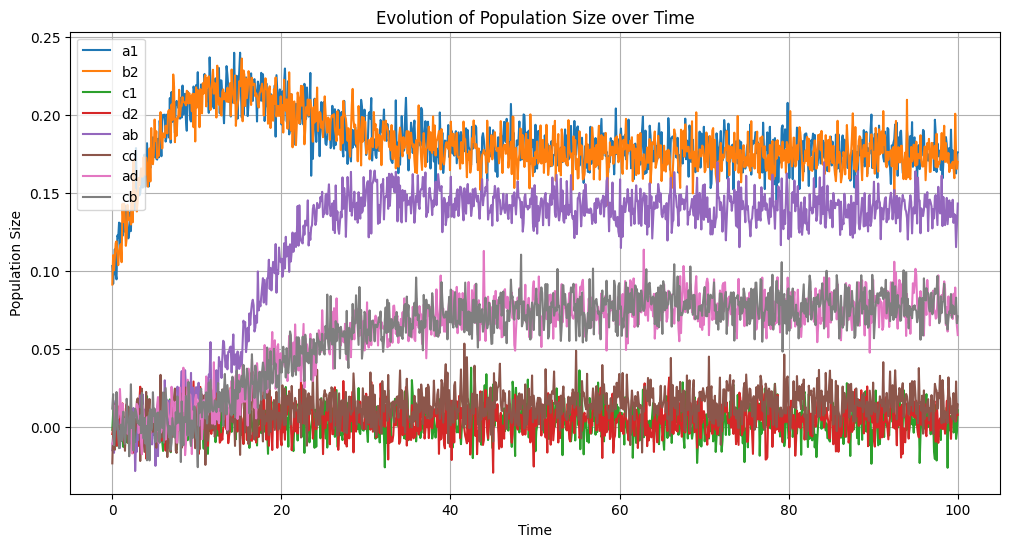

In [137]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Time points
T = 100
t = np.linspace(0, T, 1000)
# Let's set intrinsic growth rates such that r_i > 0
r = 0.3*np.ones(n); print ('r', r)

# Define the system of differential equations
def dXdt(X, t):
  return X * (r + np.dot(A, X))

def run_glv(init_tokens = [], select = None, on = 0.1, off = 0.001, show = True):

  # Number of species
  n = len(tokens)

  # Initial conditions: start with equal populations
  X0 = off*np.ones(n)
  for init_token in init_tokens:
    i0 = tokens.index(init_token)
    X0[i0] = on

  # Solve the system of differential equations
  solution = odeint(dXdt, X0, t)

  if show:
    if select is None:
      select = tokens
    plt.figure(figsize=(12, 6)); print ('solution.shape', solution.shape)
    for i in range(solution.shape[1]):
        if tokens[i] in select:
          plt.plot(t, solution[:, i] +0.01*np.random.randn(solution.shape[0]), label=tokens[i])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Evolution of Population Size over Time')
    plt.grid(True)
    plt.show()

  return solution

print (tokens)
select = tokens
solution = run_glv(init_tokens = ['a1', 'b2'], select = select, show = True)

In [138]:
def jacobian(func, state, interaction_matrix, growth_rates):
    """Compute the Jacobian matrix of func at the given state."""
    n = len(state)
    jacobian_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                jacobian_matrix[i, j] = state[i] * (interaction_matrix[i, j] + int(i == j) * growth_rates[i])
            else:
                jacobian_matrix[i, j] = state[i] * (interaction_matrix[i, i] + growth_rates[i] + 2 * sum(interaction_matrix[i, k] * state[k] for k in range(n) if k != i))

    return jacobian_matrix

def check_stability(func, state, interaction_matrix, growth_rates):
    """Compute the Jacobian of func at the given state, check its stability, and display it."""
    # Compute the Jacobian
    jacobian_matrix = jacobian(func, state, interaction_matrix, growth_rates)

    # Compute the eigenvalues of the Jacobian
    eigenvalues = np.linalg.eigvals(jacobian_matrix)

    # Check if the real parts of all eigenvalues are negative
    is_stable = np.all(np.real(eigenvalues) < 0)

    # Display the Jacobian
    plt.figure(figsize=(6, 6))
    plt.imshow(jacobian_matrix, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title('Stable Jacobian at equilibrium' if is_stable else 'Unstable Jacobian at equilibrium')
    plt.show()

    return is_stable

# Compute the equilibrium
if np.linalg.det(A) != 0:
    equilibrium = -np.linalg.inv(A) @ r
    if np.all(equilibrium >= 0):  # Check if the equilibrium is feasible
        feasible_equilibrium = equilibrium
    else:
        feasible_equilibrium = None
else:
    feasible_equilibrium = None

# Compute the Jacobian at the feasible equilibrium and print the real parts of its eigenvalues
if feasible_equilibrium is not None:
    jacobian_at_equilibrium = jacobian(dXdt, feasible_equilibrium, A, r)
    eigenvalues = np.linalg.eigvals(jacobian_at_equilibrium)
    print("Real parts of the eigenvalues of the Jacobian at the feasible equilibrium:")
    print(np.real(eigenvalues))
    check_stability(dXdt, feasible_equilibrium, A, r)
else:
    print("The system does not have a feasible equilibrium.")
    print ('det(A)', np.linalg.det(A))
    print (-np.linalg.inv(A) @ r)

The system does not have a feasible equilibrium.
det(A) 6.48521094964921e-05
[ 0.41294356  0.33179683 -0.23433302 -0.15279661  0.28204182 -0.12579246
  0.10645655  0.0495408 ]


In [139]:
import plotly.express as px
import numpy as np
import pandas as pd
from scipy.linalg import svd

# Perform Singular Value Decomposition (SVD) on the interaction matrix
U, S, Vt = svd(A)

# Select the top 3 modes
modes = Vt[:3, :]


# project initial trajectory onto modes
projection = solution @ modes.T


# Set initial state for C1, D2
initial_state_new1 = [0.001, 0.001, 0.1, 0.1, 0.001, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
solution_new = odeint(dXdt, initial_state_new1, t)

# Project the state's evolution with the new initial state onto the 3D space spanned by the top 3 modes
projection_new = solution_new @ modes.T


# Set initial state for A1, D2
initial_state_new2 = [0.1, 0.001, 0.001, 0.1, 0.001, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
solution_new2 = odeint(dXdt, initial_state_new2, t)

# Project the state's evolution with the new initial state onto the 3D space spanned by the top 3 modes
projection_new2 = solution_new2 @ modes.T


# Set initial state for C1, B2
initial_state_new3 = [0.001, 0.1, 0.1, 0.001, 0.001, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
solution_new3 = odeint(dXdt, initial_state_new3, t)

# Project the state's evolution with the new initial state onto the 3D space spanned by the top 3 modes
projection_new3 = solution_new3 @ modes.T

# Prepare a new color gradient to signify time
#colors_new2 = plt.cm.summer(np.linspace(0, 1, len(t)))



if feasible_equilibrium is not None:

  # Project the equilibrium onto the 3D space spanned by the top 3 modes
  equilibrium_projection = equilibrium @ modes.T

In [140]:
import plotly.graph_objects as go

# Create a DataFrame for each trajectory and then combine them
df1 = pd.DataFrame(projection, columns=['Mode 1', 'Mode 2', 'Mode 3'])
df1['Time'] = np.arange(len(df1))
df1['Type'] = 'A1, B2'

df2 = pd.DataFrame(projection_new, columns=['Mode 1', 'Mode 2', 'Mode 3'])
df2['Time'] = np.arange(len(df2))
df2['Type'] = 'C1, D2'

df3 = pd.DataFrame(projection_new2, columns=['Mode 1', 'Mode 2', 'Mode 3'])
df3['Time'] = np.arange(len(df3))
df3['Type'] = 'A1, D2'

df4 = pd.DataFrame(projection_new3, columns=['Mode 1', 'Mode 2', 'Mode 3'])
df4['Time'] = np.arange(len(df4))
df4['Type'] = 'C1, B2'

df1['Time'] = df1['Time'] / df1['Time'].max()
df2['Time'] = df2['Time'] / df2['Time'].max()
df3['Time'] = df3['Time'] / df3['Time'].max()
df4['Time'] = df4['Time'] / df4['Time'].max()

df = pd.concat([df1, df2, df3, df4])

fig = go.Figure()

# Custom color scales
custom_green_scale = [[0, '#90EE90'], [1, '#004D00']]  # LightGreen to VeryDarkGreen
custom_blue_scale = [[0, '#87CEFA'], [1, '#00004D']]  # LightSkyBlue to VeryDarkBlue
custom_red_scale = [[0, '#FF7F7F'], [1, '#4D0000']]  # LightCoral to VeryDarkRed
custom_gray_scale = [[0, '#D3D3D3'], [1, '#2F4F4F']]  # LightGray to DarkSlateGray

# Create a scatter plot for each trajectory
for type, color_scale, init_color in [('A1, B2', custom_green_scale, '#90EE90'), ('C1, D2', custom_blue_scale, '#87CEFA'), ('A1, D2', custom_red_scale, '#FF7F7F'), ('C1, B2', custom_gray_scale, '#D3D3D3')]:
    df_sub = df[df['Type'] == type].copy()
    df_sub['Time'] = (df_sub['Time'] - df_sub['Time'].min()) / (df_sub['Time'].max() - df_sub['Time'].min())

    # Regular trajectory
    fig.add_trace(go.Scatter3d(x=df_sub['Mode 1'], y=df_sub['Mode 2'], z=df_sub['Mode 3'],
                               mode='markers',
                               marker=dict(size=6, color=df_sub['Time'], colorscale=color_scale),
                               name=type,
                               legendgroup=type,
                               showlegend=False))

    # Start point
    fig.add_trace(go.Scatter3d(x=[df_sub['Mode 1'].iloc[0]], y=[df_sub['Mode 2'].iloc[0]], z=[df_sub['Mode 3'].iloc[0]],
                               mode='markers',
                               marker=dict(size=10, color=init_color),
                               name=type+' start',
                               legendgroup=type))

# Add the equilibrium point (if it exists)
if feasible_equilibrium is not None:
    fig.add_trace(go.Scatter3d(x=[equilibrium_projection[0]],
                               y=[equilibrium_projection[1]],
                               z=[equilibrium_projection[2]],
                               mode='markers',
                               marker=dict(size=6, color='black'),
                               name='Equilibrium'))

# Update layout
fig.update_layout(scene=dict(xaxis_title='Mode 1', yaxis_title='Mode 2', zaxis_title='Mode 3'),
                  title_text="Projection of State Evolutions onto Top 3 Modes with Different Initial States")

fig.show()


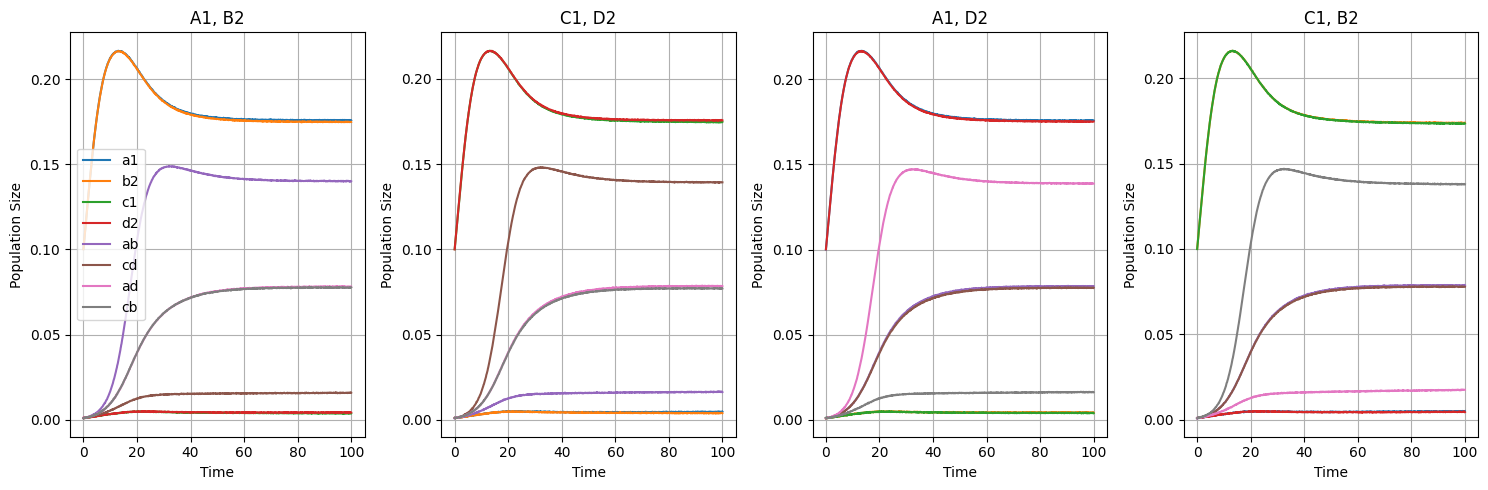

In [141]:
# Plot the results

# Adjust the figsize here to make the plot wider
plt.figure(figsize=(15, 5))  # You can adjust the first value to increase or decrease width

for k, (title, X) in enumerate(zip(['A1, B2', 'C1, D2', 'A1, D2', 'C1, B2'], [solution, solution_new, solution_new2, solution_new3])):
    plt.subplot(1,4,k+1)
    for i in range(X.shape[1]):
        if tokens[i] in select:
            plt.plot(t, X[:, i] + 0.0001*np.random.randn(X.shape[0]), label=tokens[i])
    if k == 0:

      plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title(title)
    plt.grid(True)

plt.tight_layout()  # This can help ensure that the subplots don't overlap
plt.show()

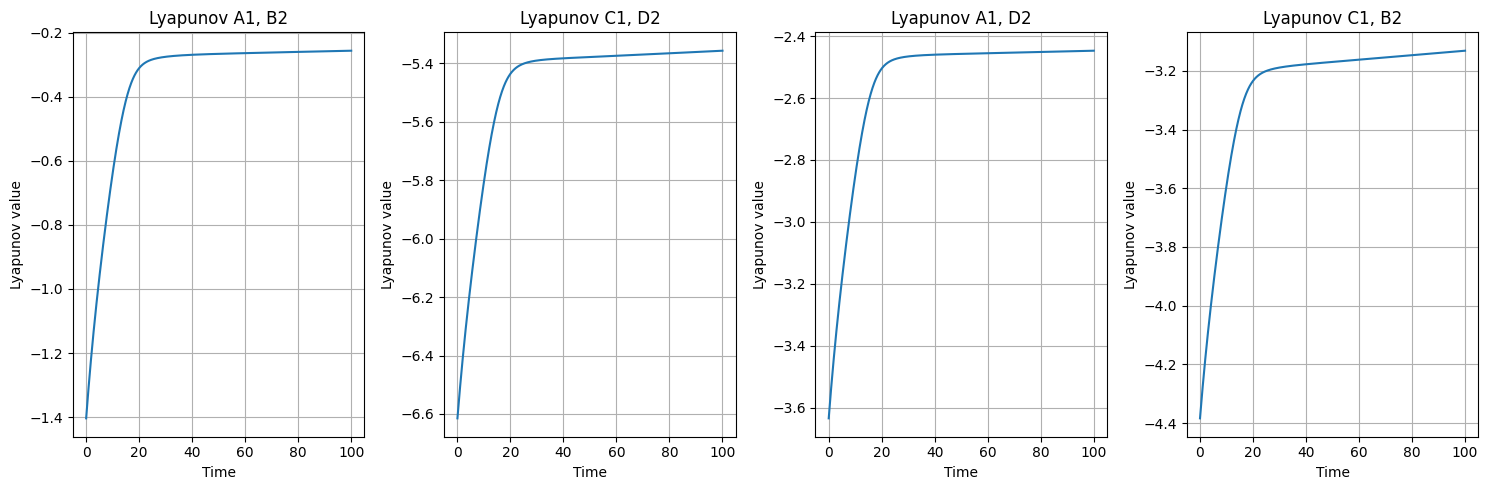

In [142]:
#taking a look at Lyapunov
#this function is a good candidate when the equilibrium is feasible

def ReLU(x):
    return x * (x > 0)

def Lyapunov(x=None, x_hat=None, c=None):
  eps=1E-6
  if len(x.shape) == 1:
    return -np.sum(c*(x_hat*np.log(x+eps)-x))
  if len(x.shape) == 2:
    return -np.sum(c*(x_hat*np.log(x+eps)-x), axis=1)

# candidate equilibrium
x_hat = -np.linalg.inv(A) @ r

# Plot the lyapunov evolution

# Adjust the figsize here to make the plot wider
plt.figure(figsize=(15, 5))  # You can adjust the first value to increase or decrease width

for k, (title, traj) in enumerate(zip(['Lyapunov A1, B2', 'Lyapunov C1, D2', 'Lyapunov A1, D2', 'Lyapunov C1, B2'], [solution, solution_new, solution_new2, solution_new3])):
    plt.subplot(1,4,k+1)
    vHistory = Lyapunov(x=traj, x_hat=x_hat, c=-np.ones(n)) #must multiply by -1 when equilibrium is not feasible ?
    plt.plot(t, vHistory)

    plt.xlabel('Time')
    plt.ylabel('Lyapunov value')
    plt.title(title)
    plt.grid(True)

plt.tight_layout()  # This can help ensure that the subplots don't overlap
plt.show()

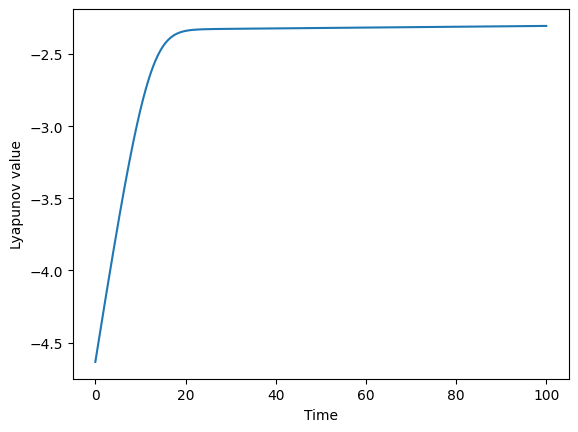

In [143]:
#reality check Lyapunov
# Set initial state
init = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
sol = odeint(dXdt, init, t)
vHistory = Lyapunov(x=sol, x_hat=x_hat, c=-np.ones(n))

#plot
plt.plot(t, vHistory)
plt.xlabel('Time')
plt.ylabel('Lyapunov value')
plt.show()

##Scaling

In [144]:
def loadWords(filename='1000TopFreqEnglishWords.txt', start=0, numwords=10, lenwords=1):
  with open(prefix+filename) as f:
    wordlist = []
    for line in f:
        w = line.strip()
        if len(w) > lenwords:
          wordlist.append(w)
  return wordlist[start: start+numwords]

def buildLetters(wordlist):
  allletters = []
  for i, word in enumerate(wordlist):
    letters = [let+str(j+1) for j, let in enumerate(word)]
    allletters += letters
  letterlist = sorted(list(set(allletters)))
  return letterlist

def buildList(numwords=10, lenwords=2):
  #wordlist = loadWords(numwords=numwords, lenwords=lenwords)
  wordlist = ['the', 'of', 'to', 'you', 'and', 'a', 'in', 'is', 'it', 'that', 'what']
  letterlist = buildLetters(wordlist)
  return wordlist, letterlist + wordlist

words, tokens = buildList(); n = len(tokens)

28


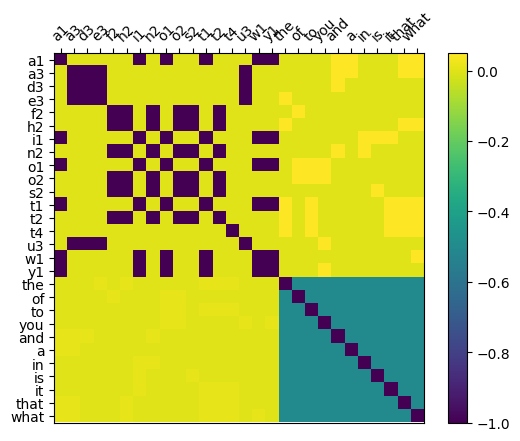

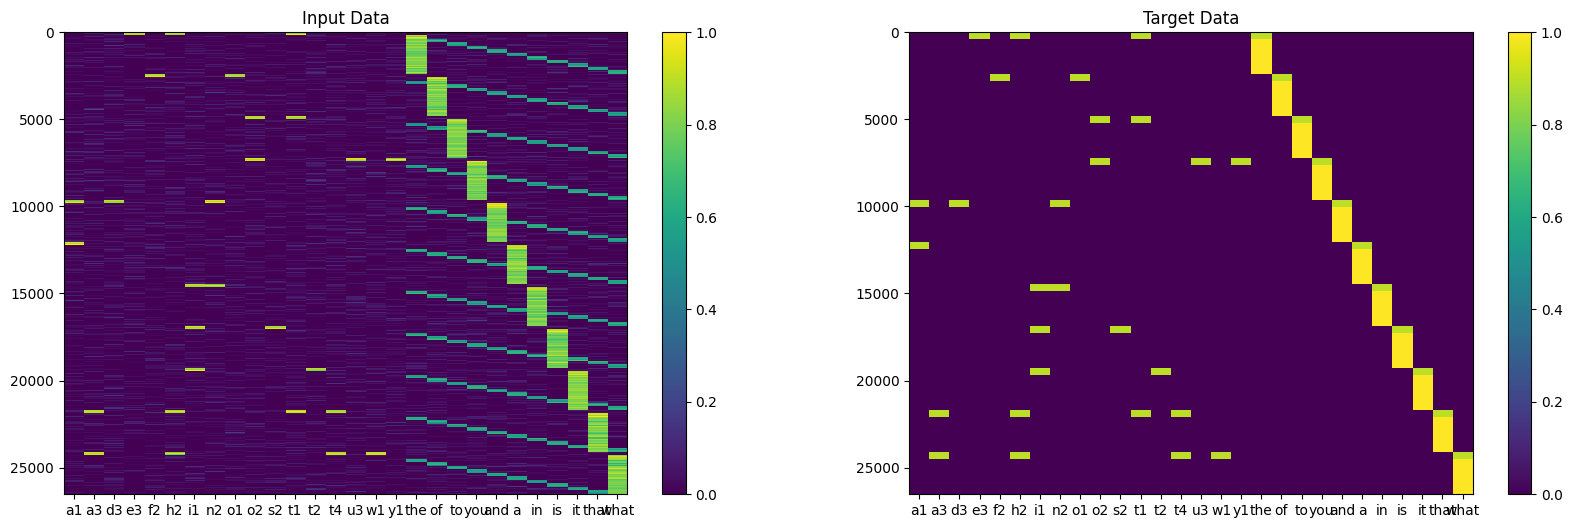

In [145]:
#create matrix and dataset
A = create_matrix(tokens);
input_data, target_data = create_dataset_expanded(tokens)

In [146]:
def show_constraints(state_history):

  iters, loss_history = zip(
      *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
    )

  mult_hist = [_["dual"][1].data.numpy() for (foo, _) in state_history.items()]
  eq_defect_hist = [_["cmp"].eq_defect.data.numpy() for (foo, _) in state_history.items()]
  ineq_defect_hist = [_["cmp"].ineq_defect.data.numpy() for (foo, _) in state_history.items()]

  plt.figure(figsize=(12, 5))

  plt.subplot(131)
  plt.plot(iters, ineq_defect_hist)
  plt.axhline(0.0, c="r", alpha=0.2)
  plt.title('inequality constraint satisfaction (neg is ok)')

  plt.subplot(132)
  plt.plot(iters, eq_defect_hist)
  plt.axhline(0.0, c="r", alpha=0.2)
  plt.title('equality constraint violations (should be 0)')

  plt.subplot(133)
  plt.plot(iters, loss_history)
  plt.title('Loss history')

  plt.tight_layout()
  plt.show()



### Train model with lagrangian

A.shape (28, 28)
inputs.size() torch.Size([26532, 28])


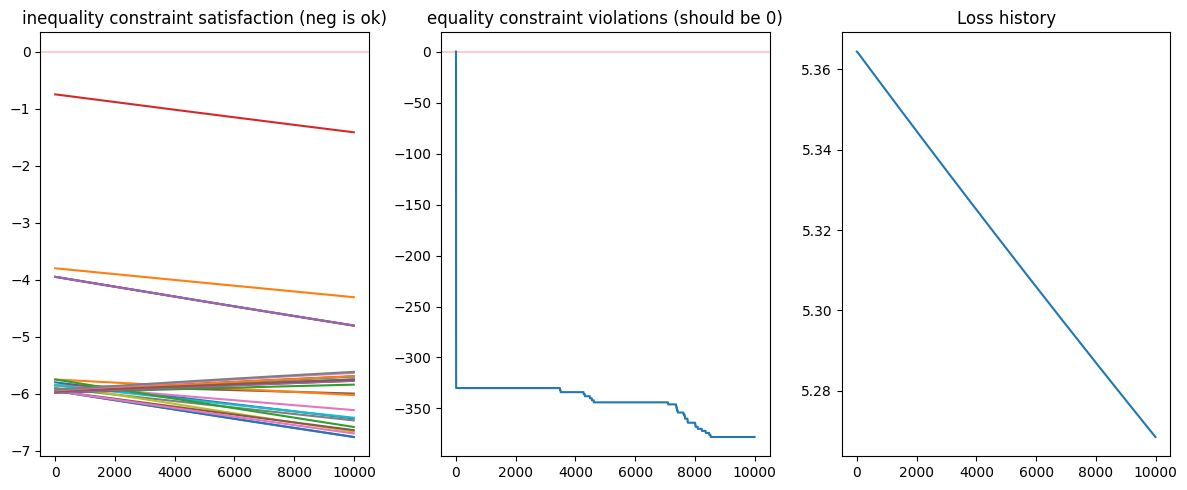

max_real_part 0.27550155
All eigenvalues have negative real parts: True
The sum of each row is negative: True
The matrix contains positive elements: True


(True, True, True)

In [147]:
cmp = TemplateSumConstrainedLogRegMod()
formulation = cooper.LagrangianFormulation(cmp)

#model = LogisticRegressionFixed(A.shape[0], A.shape[1])
model = LogisticRegression(A.shape[0], A.shape[1]);print ('A.shape',A.shape)
# Initialize the model's weights with A
A_tensor = torch.tensor(A, dtype=torch.float32)
model.linear.weight.data = nn.Parameter(A_tensor)

# primal_optimizer = cooper.optim.ExtraSGD(model.parameters(), lr=1e-3, momentum=0.9)
# dual_optimizer = cooper.optim.partial_optimizer(cooper.optim.ExtraSGD, lr=5e-3)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=5e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

epochs = 10000
iter_num = 0
state_history = OrderedDict()

# shuffle
shuffled_indices = np.arange(len(input_data))
np.random.shuffle(shuffled_indices)
input_data_shuffled = input_data[shuffled_indices]
target_data_shuffled = target_data[shuffled_indices]

# Set the diagonal elements to -1
#np.fill_diagonal(A, -1)
template = torch.from_numpy(np.sign(A)).float()
inputs = torch.from_numpy(input_data_shuffled).float();print ('inputs.size()', inputs.size())
targets = torch.from_numpy(target_data_shuffled).float()

for epoch in range(epochs):
      coop.zero_grad()
      lagrangian = formulation.composite_objective(
          cmp.closure, model, inputs, targets, template
        )
      formulation.custom_backward(lagrangian)
      coop.step(cmp.closure, model, inputs, targets, template)

      if iter_num % 5 == 0:
          state_history[iter_num] = {
                "cmp": cmp.state,
                "dual": copy(formulation.state()),
            }

      iter_num += 1


show_constraints(state_history)
A = model.linear.weight.detach().numpy()
A = adjust_eigen(A)
A = 0.01*A
check_matrix_conditions(A)

### Visualize a trajectory

['a1', 'a3', 'd3', 'e3', 'f2', 'h2', 'i1', 'n2', 'o1', 'o2', 's2', 't1', 't2', 't4', 'u3', 'w1', 'y1', 'the', 'of', 'to', 'you', 'and', 'a', 'in', 'is', 'it', 'that', 'what']
r [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
All eigenvalues have negative real parts: True
The sum of each row is negative: True
The matrix contains positive elements: True
solution.shape (1000, 28)


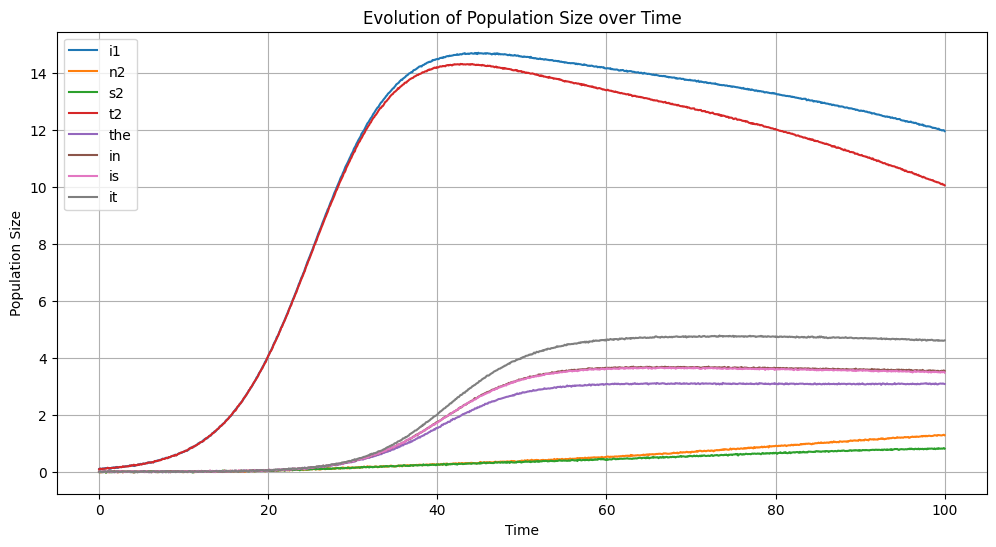

In [148]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

print (tokens)
n = len(tokens)
# Time points
T = 100
t = np.linspace(0, T, 1000)
# Let's set intrinsic growth rates such that r_i > 0
r = 0.2*np.ones(n); print ('r', r)
check_matrix_conditions(A)

solution = run_glv(init_tokens = ['i1', 't2'], select = ['i1', 't2', 's2', 'n2', 'in', 'is', 'it', 'the'], show = True)

In [149]:
# Compute the equilibrium
if np.linalg.det(A) != 0:
    equilibrium = -np.linalg.inv(A) @ r
    if np.all(equilibrium >= 0):  # Check if the equilibrium is feasible
        feasible_equilibrium = equilibrium
    else:
        feasible_equilibrium = None
else:
    feasible_equilibrium = None

# Compute the Jacobian at the feasible equilibrium and print the real parts of its eigenvalues
if feasible_equilibrium is not None:
    jacobian_at_equilibrium = jacobian(dXdt, feasible_equilibrium, A, r)
    eigenvalues = np.linalg.eigvals(jacobian_at_equilibrium)
    print("Feasible equilibrium:", feasible_equilibrium)
    print("Real parts of the eigenvalues of the Jacobian at the feasible equilibrium:")
    print(np.real(eigenvalues))
    check_stability(dXdt, feasible_equilibrium, A, r)
else:
    print("The system does not have a feasible equilibrium.")
    print ('det(A)', np.linalg.det(A))
    print (-np.linalg.inv(A) @ r)

The system does not have a feasible equilibrium.
det(A) 2.6043936834092134e-65
[-2601.78731675  5575.82665061 -3821.29863492  1631.83404004
 -1255.52072247  8227.42338072 -3003.73730866 -3607.15626702
 -1462.82692783  -861.86641399 -1646.35123306  6029.57225007
  -851.20081393  1870.68691741 -2989.85516104  3133.49941886
 -2055.88378331  1078.35620086  -502.04222462   176.40843637
  -767.03032767 -1036.56604807  -398.73074308  -822.17011318
  -644.04998204  -490.95536846  1497.12277782  1306.68866828]


### Assess performance

In [161]:
acc = 0
print ('words', words); lw = len(words); ll = len(tokens) - lw
reality_check = False
colors = 1000*['lightblue', 'lightgreen', 'teal', 'darkgreen', 'darkblue', 'blue', 'green','orange']
on, off = 1.0, 1E-12
for i, word in enumerate(words):
    strings = [let+str(j+1) for j, let in enumerate(word)]
    xHistory = run_glv(init_tokens = strings, select = strings + words, show = False, on = on, off = off)
    bestwordIndex = np.argmax(xHistory[-1, -lw:])

    if bestwordIndex == i:
      print ('ok')
      acc += 1
    if reality_check:
      #reality check
      for k in range(lw):
        if k == bestwordIndex:
          plt.plot(xHistory[:,ll+k], c='red', label=words[k])

        else:
          plt.plot(xHistory[:,ll+k], c='black')
      plt.title('input:'+' '.join(strings))
      plt.legend()
      plt.show()
    #plot(X_history=xHistory, L1=L1, L2=L2, inputs=strings, colors=colors)
print ('Accuracy (%):', 100*acc/lw)

words ['the', 'of', 'to', 'you', 'and', 'a', 'in', 'is', 'it', 'that', 'what']
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
Accuracy (%): 100.0
